In [1]:
# Elementos de matriz y funciones personalizadas
from elementos_matriz import *
from graficar import plt, graficarVQE

# Qiskit circuitos
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
# Qiskit simulaciones
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator

# Minimizador
from scipy.optimize import minimize

# Simulaciones con ruido
from qiskit_ibm_runtime import QiskitRuntimeService

## Métodos clásicos

In [2]:
# cargar elementos de matriz previamente calculados
distancias, h11, h22, J11, J22, J12, K12, hnuc = elementos_H2('cargar')

Elementos de matriz y distancias interatómicas cargadas.


In [3]:
RHF = cargar('H2_RHF1') # Energía Hartree-Fock restringida
UHF = cargar('H2_UHF1') # Energía Hartree-Fock sin restricción
CI = cargar('H2_CI1') # Energía CI

## VQE

In [4]:
def loadIBMservice():
    """ Carga los servicios de IBM Quantum
    """
    # Leer el API token
    with open("ibm_token.txt", "r") as file:
        api_token = file.read().strip()
    
    # Leer el CRN
    with open("ibm_CRN.txt", "r") as file:
        CRN = file.read().strip()
    
    service = QiskitRuntimeService(channel='ibm_cloud', token=api_token, instance=CRN)
    return service

In [5]:
def H2_Hamiltoniano_JW(f11, f33, g1212, g3434, g1313, g1331):
    """ Hamiltoniano de la molécula de hidrógeno H2 mediante la transformación de Jordan-Wigner (JW)

    Parámetros
        f11 : h11
        f33 : h22
        g1212 : J11
        g3434 : J22
        g1313 : J12
        g1331 : K12
    """
    h12 = (2*f11 + g1212 + 2*g1313 - g1331)/4
    h34 = (2*f33 + g3434 + 2*g1313 - g1331)/4
    h0 = f11 + f33 + g1212/4 + g3434/4 + g1313 - g1331/2
    
    hamiltoniano = SparsePauliOp.from_list(
        [
            ("IIII", h0),
            ("IIIZ", -h12), ("IZII", -h12),
            ("IIZI", -h34), ("ZIII", -h34),
            ("IZIZ", g1212/4),
            ("IIZZ", (g1313-g1331)/4), ("ZZII", (g1313-g1331)/4),
            ("ZIIZ", g1313/4), ("XYXY", g1331/4),
            ("XYYX", -g1331/4), ("YXXY", -g1331/4),
            ("YXYX", g1331/4), ("IZZI", g1313/4),
            ("ZIZI", g3434/4),
        ]
    )
    return hamiltoniano

In [6]:
# creación del problema
num_spatial_orbitals  = 2 # dos orbitales espaciales (ligante y antiligante)
num_particles  = (1,1) # una partícula con espín arriba y otra con espín abajo
qubit_mapper  = JordanWignerMapper() # mapeo de qubits

# Estimador
estimator = Estimator()

In [7]:
def funcion_costo(params:np.ndarray, ansatz_isa, hamiltonian, estimator):
    """ Regresa el estimado de energía a partir del estimador

    Parámetros
        params: Arreglo de parámetros del ansatz
        ansatz_isa (QuantumCircuit): Circuito ansatz parametrizado
        hamiltonian (SparsePauliOp): Representación operacional del Hamiltoniano
        estimator (Estimator): Instancia de la primitiva estimador

    Devuelve
        float: Estimación de energía
    """

    pub = (ansatz_isa, hamiltonian, [params])
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]

    cost = pub_result.data.evs[0]
    return cost

In [8]:
def VQE(indice, backend=None, optimization_level=2, init_params=None):
    """ Variational Quantum Eigensolver

    Parámetros:
        indice (float):
        backend (str):
        optimization_level (int): 
        init_params (ndarray) : 

    Devuelve:
        float: Estimación de energía
    """

    # (1) Estado inicial
    init_state = HartreeFock(num_spatial_orbitals, num_particles, qubit_mapper)
    # (2.1) Ansatz
    ansatz = UCCSD(num_spatial_orbitals, num_particles, qubit_mapper, initial_state=init_state)
    # (2.2) Parámetros iniciales del ansatz
    if init_params is None:
        num_params = ansatz.num_parameters # número de parámetros T_i en el ansatz
        init_params = [0] * num_params # parámetros iniciales (todos cero)
    else:
        init_params = init_params # parámetros iniciales
    # (3) Hamiltoniano
    hamiltonian_isa = H2_Hamiltoniano_JW(h11[i], h22[i], J11[i], J22[i], J12[i], K12[i])
    
    # Simulador
    if backend is None: # sin ruido
        aer = AerSimulator()
    else: # con ruido
        service = loadIBMservice()
        real_backend = service.backend(backend) # QPU (Quantum Processing Unit) para el perfil de ruido
        aer = AerSimulator.from_backend(real_backend)
        ### Transpilar Hamiltoniano
        # se fija el número de términos de Pauli del 'SparsePauliOperator' igual que el número de qubits del simulador
        hamiltonian_isa = hamiltonian_isa.apply_layout(layout=None, num_qubits=aer.num_qubits)

    # Pass Manager
    pass_manager = generate_preset_pass_manager(backend=aer, optimization_level=optimization_level)
    ansatz_isa = pass_manager.run(ansatz)
    
    # Minimización
    vqe_energy = minimize(funcion_costo, init_params, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
    optimized_params = vqe_energy.x # parámetros optimizados

    # Resultado
    energy_H2 = vqe_energy.fun + hnuc[i] # energía total

    return optimized_params, energy_H2

### VQE sin ruido

In [9]:
%%time
print("VQE - optimización máxima - sin ruido\n")
optimized_params, VQE_energy = [], []

total = len(distancias)
counter = 10
for i in range(total):
    # Parámetros iniciales.
    ## La iteración i+1 considera como parámetros iniciales los parámetros optimizados de la i-ésima iteración
    init_params = optimized_params[i-1] if (i != 0) else None
    
    # VQE, optimización máxima, sin ruido
    params, energy = VQE(i, None, 3, init_params)
    optimized_params.append(params)
    VQE_energy.append(energy)

    val = int(np.round((i+1)*100/total))
    if val >= counter:
        print(f"{val}% de casos calculados. {i+1} de {total}.")
        counter += 10

VQE - optimización máxima - sin ruido

10% de casos calculados. 29 de 299.
20% de casos calculados. 59 de 299.
30% de casos calculados. 89 de 299.
40% de casos calculados. 119 de 299.
50% de casos calculados. 149 de 299.
60% de casos calculados. 178 de 299.
70% de casos calculados. 208 de 299.
80% de casos calculados. 238 de 299.
90% de casos calculados. 268 de 299.
100% de casos calculados. 298 de 299.
CPU times: user 5min 14s, sys: 8.13 s, total: 5min 23s
Wall time: 5min 52s


In [10]:
guardar('H2_VQE', VQE_energy)

In [11]:
# Valores de la energía en función de la distancia interatómica reportada por Kandala, et. al.
x_Kandala = np.array([0.204,0.299,0.401,0.591,0.73,0.985,1.19,1.387,1.577,1.788,1.978,2.985,3.974]) # distancia interatómica (Angstroms)
y_Kandala = np.array([0.194,-0.536,-0.848,-1.076,-1.109,-1.061,-1.039,-1.006,-0.979,-0.921,-0.936,-0.924,-0.927]) # energía (hartrees)

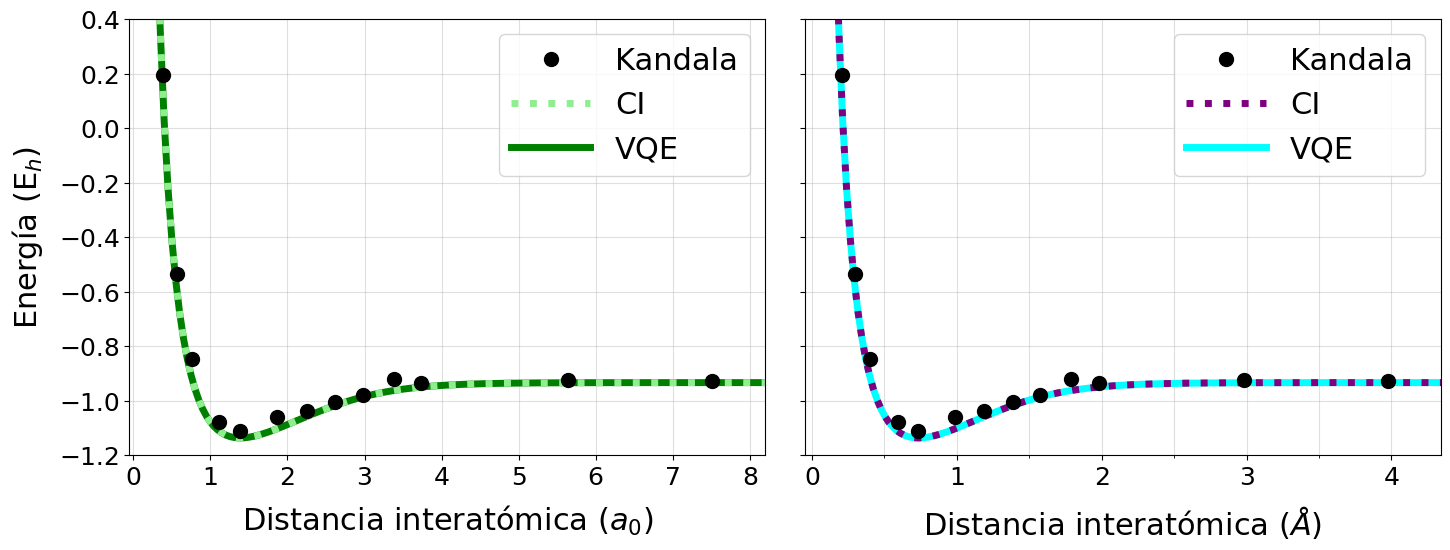

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 fila, 1 columnas, tamaño de figura (15, 5)
linewidth, fontsize, labelsize, alpha = 5, 22, 18, 0.4

factor = 0.529177249 # unidades atómicas de distancia a Angstroms
xmin, xmax = -0.05, 8.2

###################
### Gráfica derecha
###################
# axs[0].plot(distancias, UHF, linewidth=linewidth, linestyle='dashed', label='UHF', color='blue')
# axs[0].plot(distancias, RHF, linewidth=linewidth, linestyle='dotted', label='RHF', color='green')
axs[0].plot(distancias, VQE_energy, linewidth=linewidth, linestyle='solid', label='VQE', color='green')
axs[0].plot(distancias, CI, linewidth=linewidth, linestyle='dotted', label='CI', color='lightgreen')
axs[0].plot(x_Kandala/factor, y_Kandala, linewidth=None, linestyle='None', label='Kandala', color='black', marker='o', markersize=10)
# x config
axs[0].set_xticks(np.arange(0, 9, 1))
axs[0].set_xlim(xmin, xmax)
axs[0].set_xlabel(r'Distancia interatómica ($a_0$)', fontsize=fontsize, labelpad=10)
# y config
axs[0].set_ylim(-1.2,0.4)
axs[0].set_ylabel(r'Energía ($\mathrm{E}_h$)', fontsize=fontsize, labelpad=10)
# plot config
handles, labels = axs[0].get_legend_handles_labels()
order = [2,1,0]
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=fontsize, handlelength=2.6)
axs[0].tick_params(axis='both', which='major', labelsize=labelsize)
axs[0].grid(alpha=alpha)

#####################
### Gráfica izquierda
#####################
# axs[1].plot(distancias*factor, UHF, linewidth=linewidth, linestyle='dashed', label='UHF', color='orange')
# axs[0].plot(distancias, RHF, linewidth=linewidth, linestyle='dotted', label='RHF', color='green')
axs[1].plot(distancias*factor, VQE_energy, linewidth=linewidth, linestyle='solid', label='VQE', color='cyan')
axs[1].plot(distancias*factor, CI, linewidth=linewidth, linestyle='dotted', label='CI', color='purple')
axs[1].plot(x_Kandala, y_Kandala, linewidth=None, linestyle='None', label='Kandala', color='black', marker='o', markersize=10)
# x config
axs[1].set_xticks(np.arange(0, 5, 1))
axs[1].set_xticks(np.arange(0, 5, 0.5), minor=True)
axs[1].set_xlim(xmin, xmax*factor)
axs[1].set_xlabel(r'Distancia interatómica ($\AA$)', fontsize=fontsize, labelpad=10)
# y config
axs[1].set_yticks(np.arange(-1.4, 0.5, 0.2), minor=True)
axs[1].set_ylim(-1.2, 0.4)
axs[1].set(yticklabels=[])
# plot config
handles, labels = axs[1].get_legend_handles_labels()
order = [2,1,0]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=fontsize, handlelength=2.6)
axs[1].tick_params(axis='both', which='major', labelsize=labelsize)
axs[1].grid(alpha=alpha, which='both')

fig.tight_layout(pad=2.5)
plt.show()
# fig.savefig('imgs/H2_VQE.svg', format='svg', bbox_inches='tight')

### VQE con ruido
El perfil de ruido por emplear será el del QPU 'ibm_brisbane'. A continuación se imprimen algunas de sus características.

In [13]:
service = loadIBMservice()
backend = service.backend("ibm_brisbane")
 
print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
)

FileNotFoundError: [Errno 2] No such file or directory: 'ibm_token.txt'

In [ ]:
%%time
print("VQE - optimización máxima - con ruido : QPU 'ibm_brisbane'\n")
noisy_optimized_params, noisy_VQE_energy = [], []

counter = 10
for i in range(total):
    # Parámetros iniciales.
    ## La iteración i+1 considera como parámetros iniciales los parámetros optimizados de la i-ésima iteración
    init_params = noisy_optimized_params[i-1] if (i != 0) else None
    
    params, energy = VQE(distances[i], "ibm_brisbane", 3)
    noisy_optimized_params.append(params)
    noisy_VQE_energy.append(energy)

    val = int(np.round((i+1)*100/total))
    if val >= counter:
        print(f"{val}% de casos calculados. {i+1} de {total}.")
        counter += 10

In [ ]:
# VQE con ruido
noisyVQE = {'x':distances, 'y':noisy_VQE_energy, 'label':'NVQE', 'linewidth':2.5, 'linestyle':'-.', 'marker':None, 'color':'blue'}

datasets = [HF, VQE, noisyVQE]
nombre = 'noisyVQE'
graficarVQE(nombre, ref=Kandala, datasets=datasets)

In [ ]:
t0 = [params[0] for params in optimized_params]
t1 = [params[1] for params in optimized_params]
t2 = [params[2] for params in optimized_params]

noisy_t0 = [params[0] for params in noisy_optimized_params]
noisy_t1 = [params[1] for params in noisy_optimized_params]
noisy_t2 = [params[2] for params in noisy_optimized_params]

In [ ]:
plt.plot(distances, t0, label="T0")
plt.plot(distances, t1, label="T1")
plt.plot(distances, t2, label="T2")
# plt.plot(distances, VQE_energy)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ¿T0 y T1 comienzan a ser relevantes aprox en el punto de inflexión de T2?
# ¿Qué otro comportamiento podría haber alrededor de ese punto que cambie el comportamiento de T0 y T1?

In [ ]:
plt.plot(distances, noisy_t0, label="T0")
plt.plot(distances, noisy_t1, label="T1")
plt.plot(distances, noisy_t2, label="T2")
# plt.plot(distances, VQE_energy)
plt.legend()
plt.grid()
plt.show()